## Stock Price Prediction with Sentiment Analysis

In [1]:
# %%time
# !pip install charset-normalizer pandas_ta yfinance statsmodels tqdm scikit-learn tensorflow

In [2]:
%%time
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

CPU times: user 3.93 ms, sys: 3.77 ms, total: 7.69 ms
Wall time: 6.94 ms


In [3]:
%%time
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
import os

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut
import time

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


CPU times: user 4.9 s, sys: 729 ms, total: 5.63 s
Wall time: 6.68 s


In [4]:
%%time
start_time = time.time()
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/sandy/PycharmProjects/stock_market_analysis
CPU times: user 192 µs, sys: 137 µs, total: 329 µs
Wall time: 283 µs


In [5]:
%%time
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth to be the same for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(
            f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth."
        )

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.
CPU times: user 1.37 ms, sys: 1.07 ms, total: 2.44 ms
Wall time: 2.06 ms


I0000 00:00:1753787444.645983  177171 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753787444.646008  177171 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load and Analyze News Data

In [6]:
%%time
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(
        sentiment_csv_path, index_col="Date", parse_dates=True
    )

print("Sentiment data ready.")

Generating new sentiment data and saving to CSV...
Loading and selecting news data...
File path: Dataset/news_data.csv
Loaded 1400469 articles from Dataset/news_data.csv
🎯 Selected target stock: NVDA (3133 articles)
\n📰 Processing news sentiment for NVDA...
Initializing sentiment analyzer with model: ProsusAI/finbert
Using device: cpu
Analyzer initialized successfully.
Analyzing 3133 headlines in batches of 32...


  0%|          | 0/98 [00:00<?, ?it/s]

\nSentiment distribution:\n Sentiment
neutral     1573
positive     887
negative     673
Name: count, dtype: int64
\n📊 Aggregating daily sentiment scores...
DataFrame saved to Dataset/NVDA_daily_sentiment.csv
Sentiment data ready.
CPU times: user 1min 6s, sys: 10.5 s, total: 1min 16s
Wall time: 31.7 s


### Fetch Stock Data and Calculate Technical Indicators

In [7]:
%%time
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col="Date", parse_dates=True)

# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Technical indicators calculated.
CPU times: user 55.1 ms, sys: 18.7 ms, total: 73.9 ms
Wall time: 511 ms


### Prepare Data for LSTM & SVM Models

In [8]:
%%time
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.BASELINE_FEATURES,
        cfg.BASELINE_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = (
    mdl.prepare_data_for_lstm(
        enhanced_full_data,
        cfg.ENHANCED_FEATURES,
        cfg.ENHANCED_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2387, 29)
CPU times: user 6.83 ms, sys: 1.9 ms, total: 8.73 ms
Wall time: 8.06 ms


### Single Layer LSTM Models

In [9]:
%%time
print("\n--- Running Single-Layer LSTM Model ---")
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001, verbose=0
)

# early_stopping = EarlyStopping(
#     monitor="val_loss", patience=10, restore_best_weights=True, verbose=0
# )

single_lstm_model = mdl.build_single_layer_lstm(
    (X_train_tech.shape[1], X_train_tech.shape[2])
)
single_layer_lstm_history = single_lstm_model.fit(
    X_train_tech,
    y_train_tech,
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    validation_split=0.2,
    # callbacks=[reduce_lr, early_stopping],
    callbacks=[reduce_lr],
    verbose=2,
)
print("Single-Layer LSTM training complete.")


--- Running Single-Layer LSTM Model ---
Epoch 1/50
53/53 - 2s - 31ms/step - loss: 0.0031 - val_loss: 0.0057 - learning_rate: 1.0000e-03
Epoch 2/50
53/53 - 1s - 15ms/step - loss: 5.8798e-04 - val_loss: 0.0070 - learning_rate: 1.0000e-03
Epoch 3/50
53/53 - 1s - 14ms/step - loss: 4.8816e-04 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 4/50
53/53 - 1s - 15ms/step - loss: 3.8561e-04 - val_loss: 0.0040 - learning_rate: 1.0000e-03
Epoch 5/50
53/53 - 1s - 15ms/step - loss: 2.9758e-04 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 6/50
53/53 - 1s - 14ms/step - loss: 3.2073e-04 - val_loss: 0.0049 - learning_rate: 1.0000e-03
Epoch 7/50
53/53 - 1s - 15ms/step - loss: 2.5587e-04 - val_loss: 0.0041 - learning_rate: 1.0000e-03
Epoch 8/50
53/53 - 1s - 14ms/step - loss: 2.2711e-04 - val_loss: 0.0027 - learning_rate: 1.0000e-03
Epoch 9/50
53/53 - 1s - 16ms/step - loss: 2.3917e-04 - val_loss: 0.0024 - learning_rate: 1.0000e-03
Epoch 10/50
53/53 - 1s - 15ms/step - loss: 2.5955e-04 - val_los

Plot saved to Output/NVDA_Single-Layer_LSTM_analysis.png


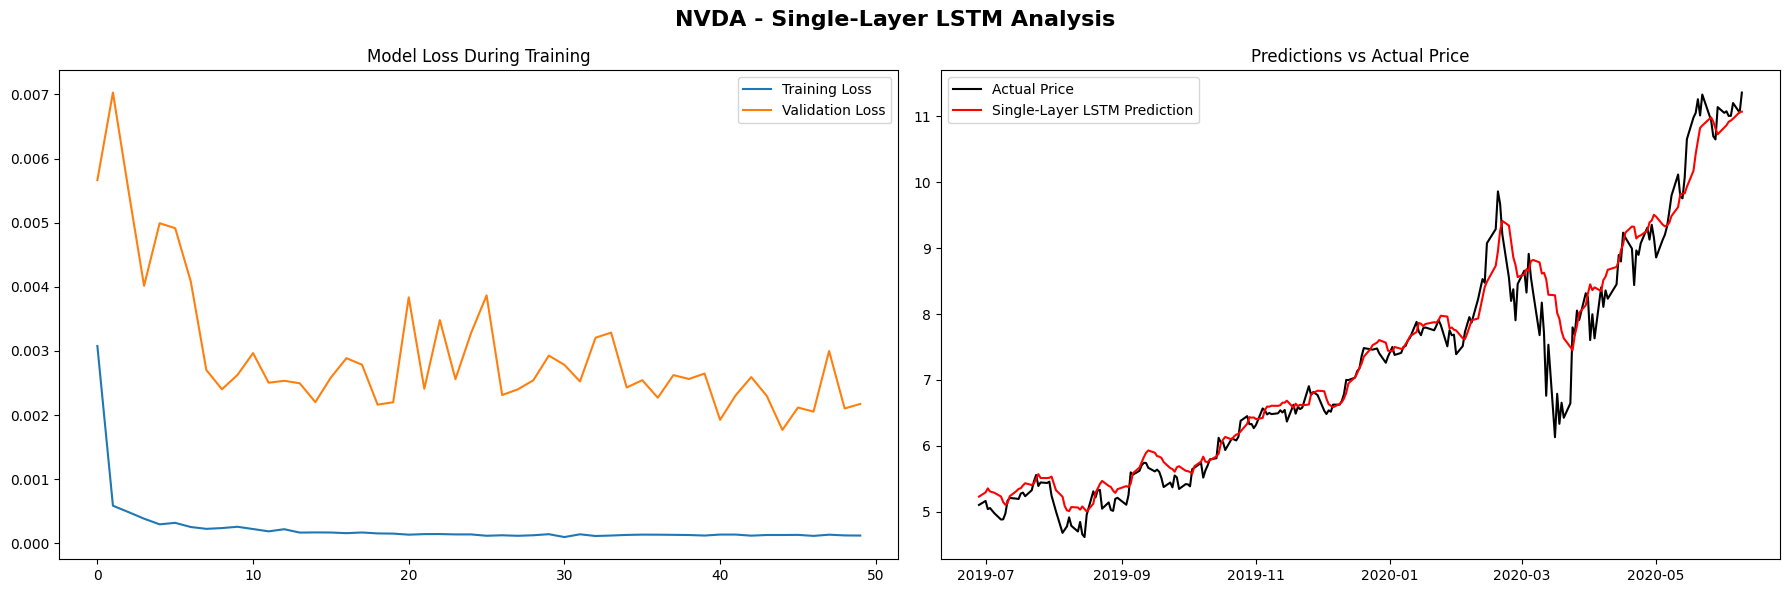

CPU times: user 418 ms, sys: 34.3 ms, total: 452 ms
Wall time: 468 ms


In [10]:
%%time
single_layer_lstm_preds = single_lstm_model.predict(X_test_tech, verbose=0)

close_scaler = MinMaxScaler().fit(
    tech_data[["Close"]]
)

y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(single_layer_lstm_preds)
baseline_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_preds_scaled, "Single-Layer LSTM"
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled):]
ut.plot_model_results(
    single_layer_lstm_history,
    y_test_tech_scaled,
    base_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Single-Layer LSTM",
)

### Multi Layer LSTM Models

In [11]:
%%time
print("\n--- Running Multi-Layer LSTM Model ---")
multi_layer_model = mdl.build_multi_layer_lstm(
    (X_train_tech.shape[1], X_train_tech.shape[2])
)
multi_layer_history = multi_layer_model.fit(
    X_train_tech,
    y_train_tech,
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    validation_split=0.2,
    # callbacks=[reduce_lr, early_stopping],
    callbacks=[reduce_lr],
    verbose=2,
)
print("Multi-Layer LSTM training complete.")


--- Running Multi-Layer LSTM Model ---
Epoch 1/50
53/53 - 3s - 56ms/step - loss: 0.0038 - val_loss: 0.0099 - learning_rate: 1.0000e-03
Epoch 2/50
53/53 - 1s - 26ms/step - loss: 5.1136e-04 - val_loss: 0.0120 - learning_rate: 1.0000e-03
Epoch 3/50
53/53 - 1s - 23ms/step - loss: 6.4722e-04 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 4/50
53/53 - 1s - 24ms/step - loss: 4.8883e-04 - val_loss: 0.0081 - learning_rate: 1.0000e-03
Epoch 5/50
53/53 - 1s - 25ms/step - loss: 4.4962e-04 - val_loss: 0.0119 - learning_rate: 1.0000e-03
Epoch 6/50
53/53 - 1s - 28ms/step - loss: 4.5637e-04 - val_loss: 0.0140 - learning_rate: 1.0000e-03
Epoch 7/50
53/53 - 1s - 25ms/step - loss: 4.3817e-04 - val_loss: 0.0076 - learning_rate: 1.0000e-03
Epoch 8/50
53/53 - 1s - 26ms/step - loss: 4.3190e-04 - val_loss: 0.0151 - learning_rate: 1.0000e-03
Epoch 9/50
53/53 - 1s - 26ms/step - loss: 3.8164e-04 - val_loss: 0.0124 - learning_rate: 1.0000e-03
Epoch 10/50
53/53 - 1s - 26ms/step - loss: 3.5342e-04 - val_loss

Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


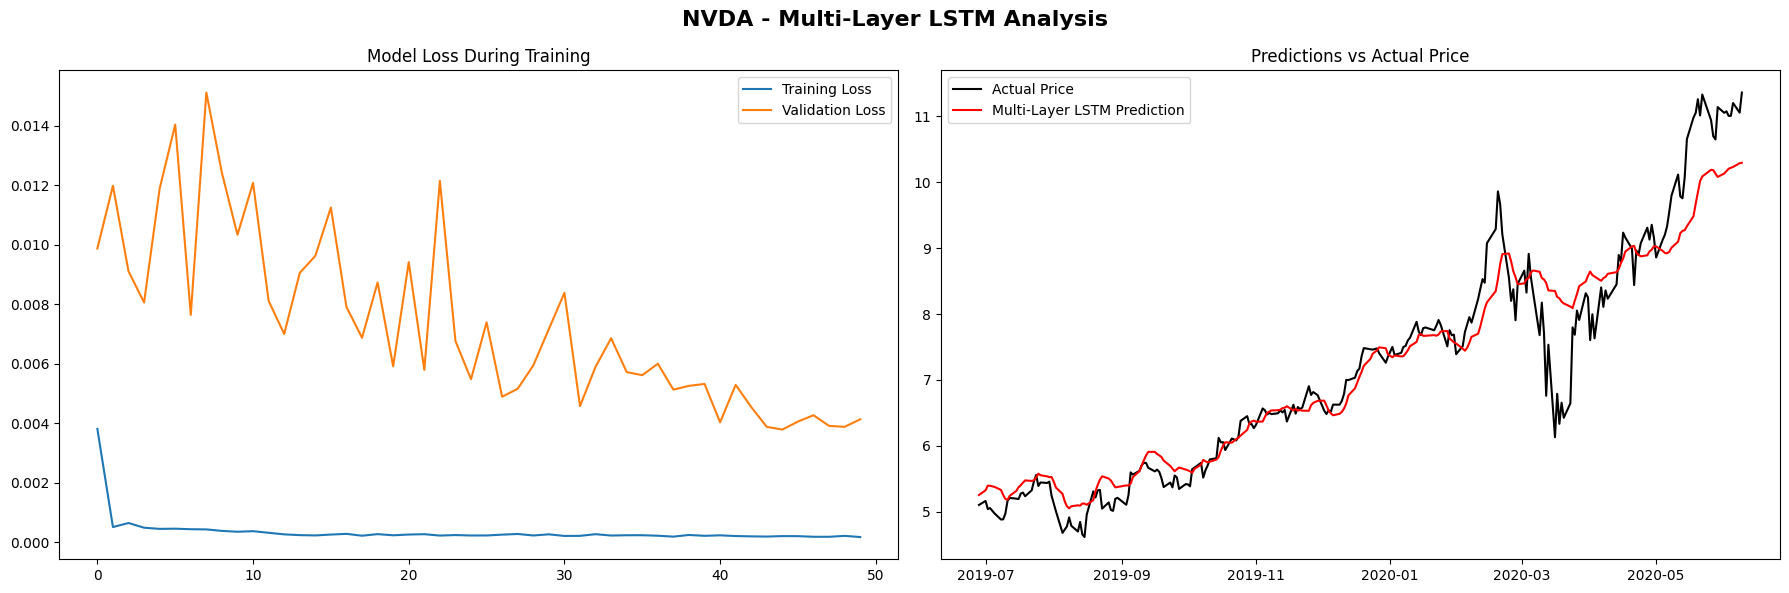

CPU times: user 504 ms, sys: 34.7 ms, total: 539 ms
Wall time: 553 ms


In [12]:
%%time
multi_preds = multi_layer_model.predict(X_test_tech, verbose=0)
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)
multi_layer_metrics = ut.calculate_metrics(
    y_test_tech_scaled, multi_preds_scaled, "Multi-Layer LSTM"
)
ut.plot_model_results(
    multi_layer_history,
    y_test_tech_scaled,
    multi_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Multi-Layer LSTM",
)

### Single-Layer Enhanced LSTM Model

In [13]:
%%time
print("\n--- Running Enhanced LSTM Model (Single-Layer) ---")
enhanced_model = mdl.build_single_layer_lstm(
    (X_train_enh.shape[1], X_train_enh.shape[2])
)
enhanced_history = enhanced_model.fit(
    X_train_enh,
    y_train_enh,
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    validation_split=0.2,
    # callbacks=[reduce_lr, early_stopping],
    callbacks=[reduce_lr],
    verbose=2,
)
print("Enhanced LSTM training complete.")


--- Running Enhanced LSTM Model (Single-Layer) ---
Epoch 1/50
53/53 - 2s - 33ms/step - loss: 0.0029 - val_loss: 0.0076 - learning_rate: 1.0000e-03
Epoch 2/50
53/53 - 1s - 14ms/step - loss: 6.8208e-04 - val_loss: 0.0078 - learning_rate: 1.0000e-03
Epoch 3/50
53/53 - 1s - 14ms/step - loss: 4.3454e-04 - val_loss: 0.0069 - learning_rate: 1.0000e-03
Epoch 4/50
53/53 - 1s - 14ms/step - loss: 4.3396e-04 - val_loss: 0.0072 - learning_rate: 1.0000e-03
Epoch 5/50
53/53 - 1s - 14ms/step - loss: 3.1726e-04 - val_loss: 0.0099 - learning_rate: 1.0000e-03
Epoch 6/50
53/53 - 1s - 14ms/step - loss: 2.7680e-04 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 7/50
53/53 - 1s - 14ms/step - loss: 2.8468e-04 - val_loss: 0.0056 - learning_rate: 1.0000e-03
Epoch 8/50
53/53 - 1s - 14ms/step - loss: 2.5602e-04 - val_loss: 0.0040 - learning_rate: 1.0000e-03
Epoch 9/50
53/53 - 1s - 14ms/step - loss: 2.4151e-04 - val_loss: 0.0047 - learning_rate: 1.0000e-03
Epoch 10/50
53/53 - 1s - 14ms/step - loss: 2.2675e-0

Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


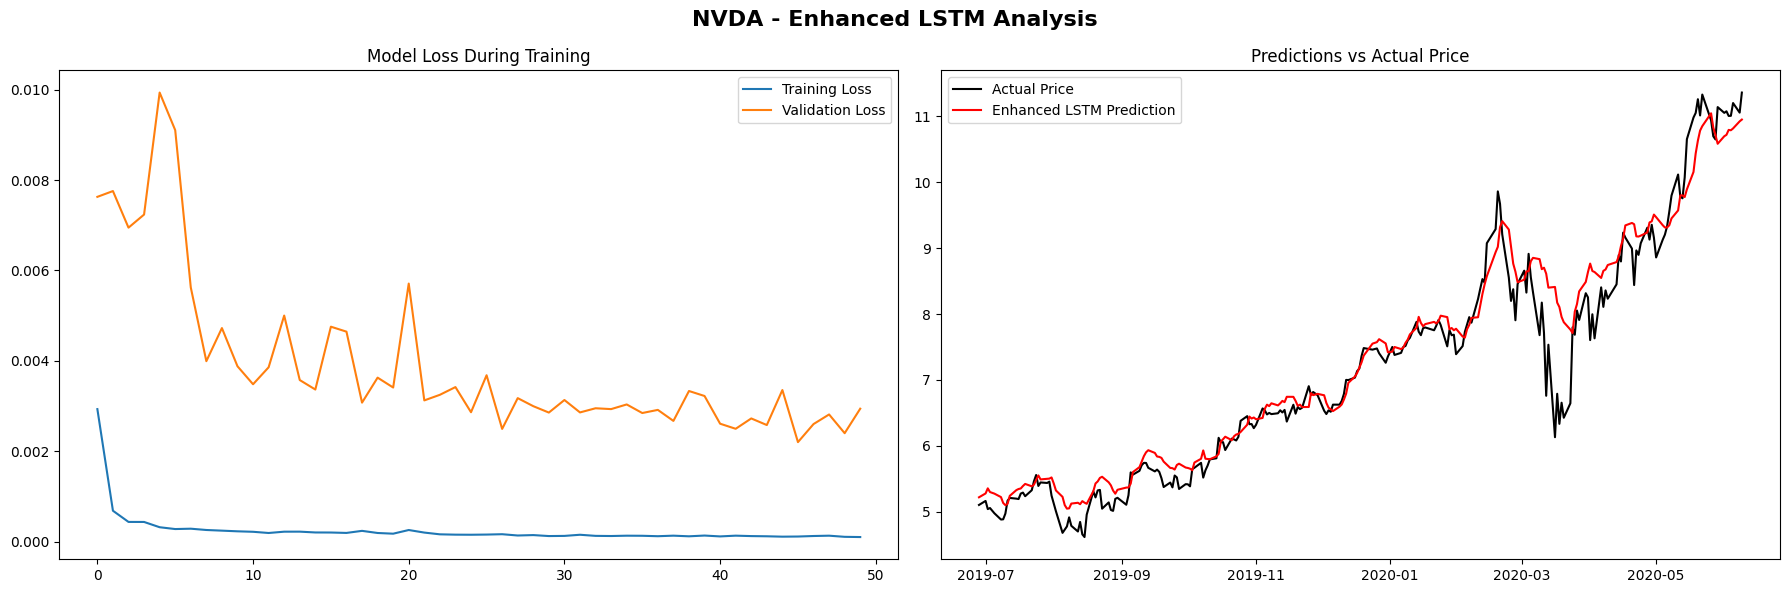

CPU times: user 369 ms, sys: 24.2 ms, total: 393 ms
Wall time: 402 ms


In [14]:
%%time
enh_preds = enhanced_model.predict(X_test_enh, verbose=0)
close_scaler_enh = MinMaxScaler().fit(enhanced_full_data[["Close"]])
y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler_enh.inverse_transform(enh_preds)
enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_preds_scaled, "Enhanced LSTM"
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]
ut.plot_model_results(
    enhanced_history,
    y_test_enh_scaled,
    enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced LSTM",
)

### Multi-Layer Enhanced LSTM Model

In [15]:
%%time
print("\n--- Running Multi-Layer Enhanced LSTM Model ---")
multi_enhanced_model = mdl.build_multi_layer_lstm(
    (X_train_enh.shape[1], X_train_enh.shape[2])
)
multi_enhanced_history = multi_enhanced_model.fit(
    X_train_enh,
    y_train_enh,
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    validation_split=0.2,
    # callbacks=[reduce_lr, early_stopping],
    callbacks=[reduce_lr],
    verbose=2,
)
print("Multi-Layer Enhanced LSTM training complete.")


--- Running Multi-Layer Enhanced LSTM Model ---
Epoch 1/50
53/53 - 3s - 49ms/step - loss: 0.0045 - val_loss: 0.0130 - learning_rate: 1.0000e-03
Epoch 2/50
53/53 - 1s - 23ms/step - loss: 7.9594e-04 - val_loss: 0.0124 - learning_rate: 1.0000e-03
Epoch 3/50
53/53 - 1s - 23ms/step - loss: 6.5459e-04 - val_loss: 0.0243 - learning_rate: 1.0000e-03
Epoch 4/50
53/53 - 1s - 23ms/step - loss: 4.9895e-04 - val_loss: 0.0086 - learning_rate: 1.0000e-03
Epoch 5/50
53/53 - 1s - 23ms/step - loss: 6.0075e-04 - val_loss: 0.0168 - learning_rate: 1.0000e-03
Epoch 6/50
53/53 - 1s - 23ms/step - loss: 3.9742e-04 - val_loss: 0.0083 - learning_rate: 1.0000e-03
Epoch 7/50
53/53 - 1s - 23ms/step - loss: 4.6155e-04 - val_loss: 0.0091 - learning_rate: 1.0000e-03
Epoch 8/50
53/53 - 1s - 24ms/step - loss: 4.4265e-04 - val_loss: 0.0090 - learning_rate: 1.0000e-03
Epoch 9/50
53/53 - 1s - 23ms/step - loss: 3.8303e-04 - val_loss: 0.0080 - learning_rate: 1.0000e-03
Epoch 10/50
53/53 - 1s - 26ms/step - loss: 5.0518e-04 -

Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


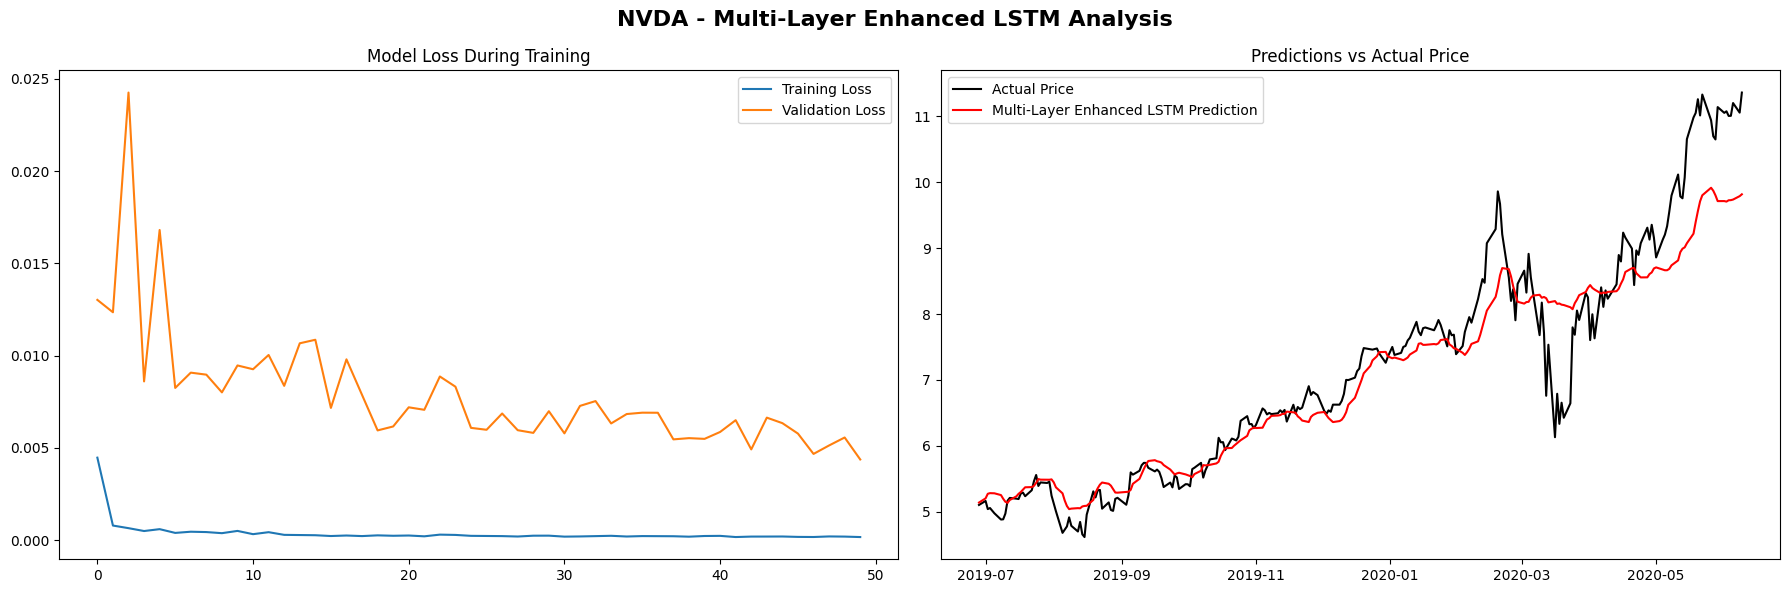

CPU times: user 476 ms, sys: 32.8 ms, total: 508 ms
Wall time: 514 ms


In [16]:
%%time
multi_enh_preds = multi_enhanced_model.predict(X_test_enh, verbose=0)
multi_enh_preds_scaled = close_scaler_enh.inverse_transform(multi_enh_preds)
multi_enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, multi_enh_preds_scaled, "Multi-Layer Enhanced LSTM"
)
ut.plot_model_results(
    multi_enhanced_history,
    y_test_enh_scaled,
    multi_enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Enhanced LSTM",
)

### Support Vector Machine (SVM) Models

In [17]:
%%time
print("\n--- Preparing Data for SVM ---")
# SVM requires 2D input, so we flatten the sequence data
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

print(f"Reshaped baseline data for SVM: {X_train_svm_tech.shape}")


--- Preparing Data for SVM ---
Reshaped baseline data for SVM: (2118, 210)
CPU times: user 164 µs, sys: 34 µs, total: 198 µs
Wall time: 178 µs


Building and training SVM model...
SVM training complete.
Plot saved to Output/NVDA_SVM_analysis.png


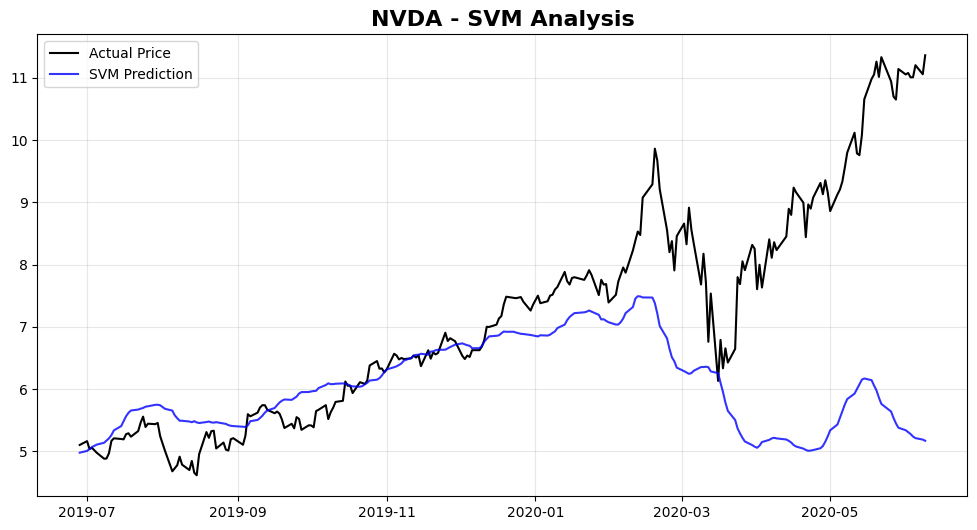

CPU times: user 114 ms, sys: 4.22 ms, total: 119 ms
Wall time: 118 ms


In [18]:
%%time
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_tech)
base_svm_preds = baseline_svm_model.predict(X_test_svm_tech)

base_svm_preds_scaled = close_scaler.inverse_transform(base_svm_preds.reshape(-1, 1))
baseline_svm_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_svm_preds_scaled, "SVM"
)
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_svm_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "SVM",
)

### GRU Model

In [19]:
%%time
print("\n--- Running Baseline GRU Model ---")
baseline_gru_model = mdl.build_gru(
    (X_train_tech.shape[1], X_train_tech.shape[2])
)
baseline_gru_history = baseline_gru_model.fit(
    X_train_tech,
    y_train_tech,
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    validation_split=0.2,
    # callbacks=[reduce_lr, early_stopping],
    callbacks=[reduce_lr],
    verbose=2,
)
print("Baseline GRU training complete.")


--- Running Baseline GRU Model ---
Epoch 1/50
53/53 - 3s - 53ms/step - loss: 0.0037 - val_loss: 0.0079 - learning_rate: 1.0000e-03
Epoch 2/50
53/53 - 1s - 21ms/step - loss: 0.0011 - val_loss: 0.0066 - learning_rate: 1.0000e-03
Epoch 3/50
53/53 - 1s - 21ms/step - loss: 9.1102e-04 - val_loss: 0.0064 - learning_rate: 1.0000e-03
Epoch 4/50
53/53 - 1s - 21ms/step - loss: 7.2096e-04 - val_loss: 0.0073 - learning_rate: 1.0000e-03
Epoch 5/50
53/53 - 1s - 23ms/step - loss: 6.0049e-04 - val_loss: 0.0053 - learning_rate: 1.0000e-03
Epoch 6/50
53/53 - 1s - 24ms/step - loss: 4.7806e-04 - val_loss: 0.0070 - learning_rate: 1.0000e-03
Epoch 7/50
53/53 - 1s - 22ms/step - loss: 4.8523e-04 - val_loss: 0.0060 - learning_rate: 1.0000e-03
Epoch 8/50
53/53 - 1s - 23ms/step - loss: 4.5333e-04 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 9/50
53/53 - 1s - 21ms/step - loss: 4.0737e-04 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 10/50
53/53 - 1s - 22ms/step - loss: 4.3969e-04 - val_loss: 0.0050

Plot saved to Output/NVDA_Baseline_GRU_analysis.png


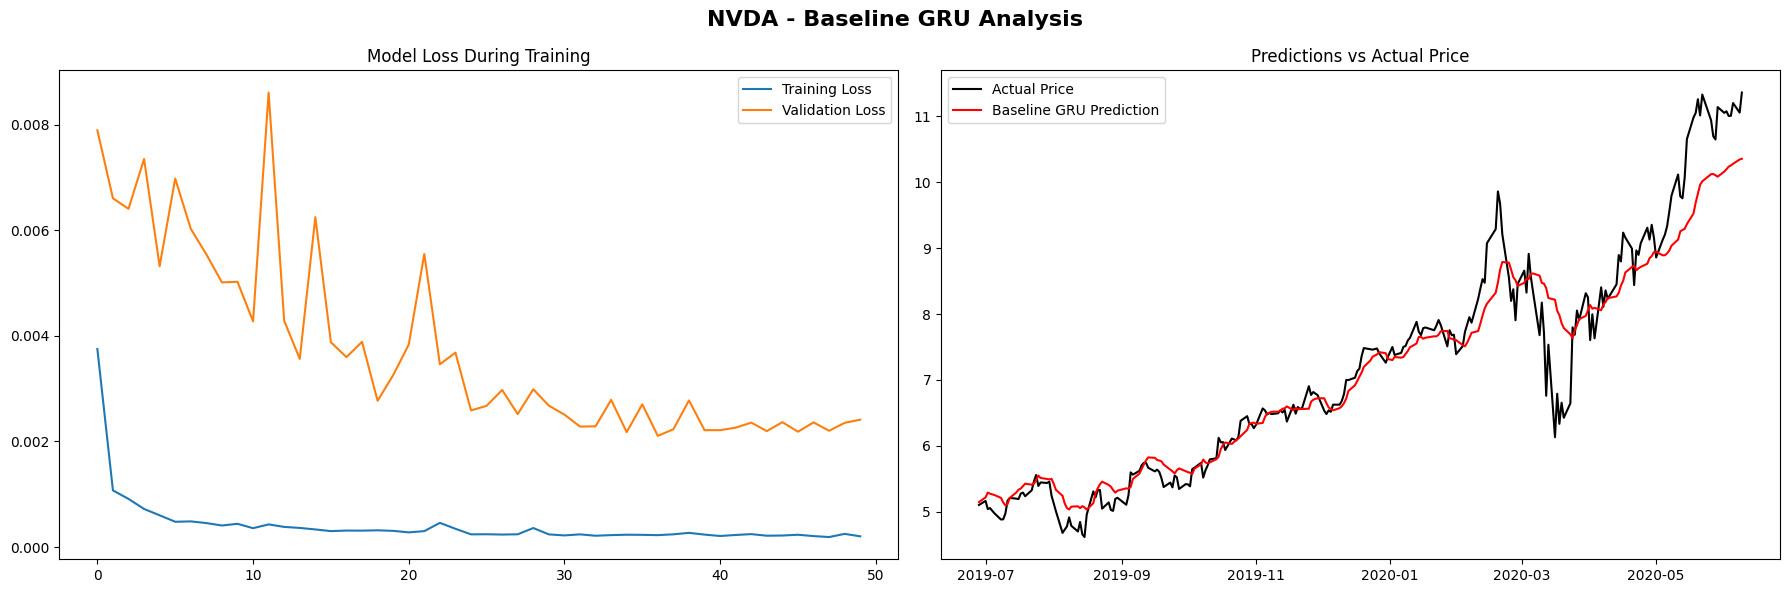

CPU times: user 445 ms, sys: 30.6 ms, total: 476 ms
Wall time: 548 ms


In [20]:
%%time
base_gru_preds = baseline_gru_model.predict(X_test_tech, verbose=0)
base_gru_preds_scaled = close_scaler.inverse_transform(base_gru_preds)
baseline_gru_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_gru_preds_scaled, "Baseline GRU"
)
ut.plot_model_results(
    baseline_gru_history,
    y_test_tech_scaled,
    base_gru_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Baseline GRU",
)

### Enhanced GRU Model

In [21]:
%%time
print("\n--- Running Enhanced GRU Model ---")
enhanced_gru_model = mdl.build_gru(
    (X_train_enh.shape[1], X_train_enh.shape[2])
)
enhanced_gru_history = enhanced_gru_model.fit(
    X_train_enh,
    y_train_enh,
    epochs=cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    validation_split=0.2,
    # callbacks=[reduce_lr, early_stopping],
    callbacks=[reduce_lr],
    verbose=2,
)
print("Enhanced GRU training complete.")


--- Running Enhanced GRU Model ---
Epoch 1/50
53/53 - 2s - 47ms/step - loss: 0.0085 - val_loss: 0.0124 - learning_rate: 1.0000e-03
Epoch 2/50
53/53 - 1s - 21ms/step - loss: 0.0016 - val_loss: 0.0055 - learning_rate: 1.0000e-03
Epoch 3/50
53/53 - 1s - 21ms/step - loss: 0.0012 - val_loss: 0.0043 - learning_rate: 1.0000e-03
Epoch 4/50
53/53 - 1s - 21ms/step - loss: 8.5185e-04 - val_loss: 0.0040 - learning_rate: 1.0000e-03
Epoch 5/50
53/53 - 1s - 21ms/step - loss: 7.3822e-04 - val_loss: 0.0039 - learning_rate: 1.0000e-03
Epoch 6/50
53/53 - 1s - 21ms/step - loss: 7.9234e-04 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 7/50
53/53 - 1s - 21ms/step - loss: 6.9842e-04 - val_loss: 0.0038 - learning_rate: 1.0000e-03
Epoch 8/50
53/53 - 1s - 21ms/step - loss: 6.0353e-04 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 9/50
53/53 - 1s - 22ms/step - loss: 6.0526e-04 - val_loss: 0.0050 - learning_rate: 1.0000e-03
Epoch 10/50
53/53 - 1s - 21ms/step - loss: 4.6030e-04 - val_loss: 0.0059 - l

Plot saved to Output/NVDA_Enhanced_GRU_analysis.png


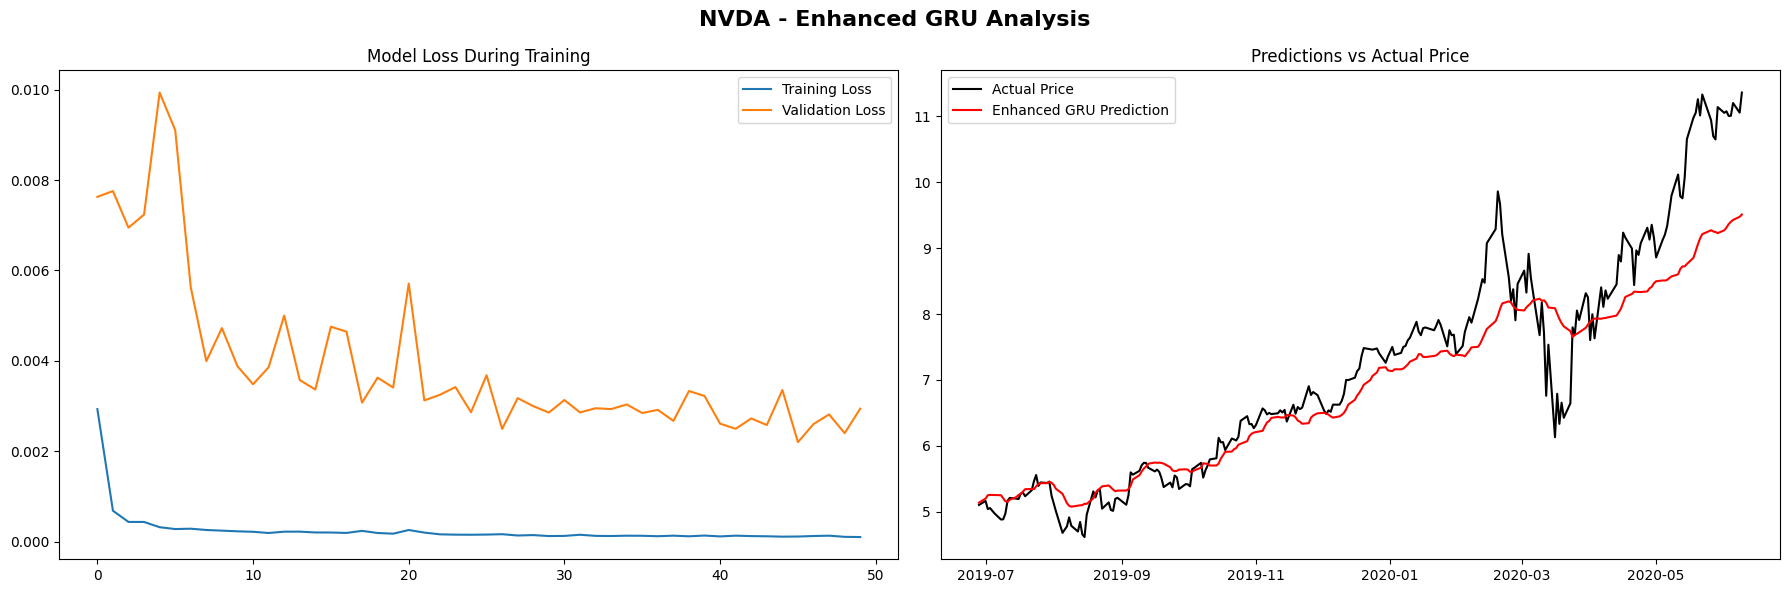

CPU times: user 445 ms, sys: 27 ms, total: 472 ms
Wall time: 484 ms


In [22]:
%%time
enh_gru_preds = enhanced_gru_model.predict(X_test_enh, verbose=0)
enh_gru_preds_scaled = close_scaler_enh.inverse_transform(enh_gru_preds)
enhanced_gru_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_gru_preds_scaled, "Enhanced GRU"
)
ut.plot_model_results(
    enhanced_history,
    y_test_enh_scaled,
    enh_gru_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced GRU",
)

### Enhanced Support Vector Machine (SVM) Models


--- Preparing Enhanced Data for SVM ---
Reshaped enhanced data for SVM: (2118, 300)
Building and training SVM model...
SVM training complete.
Plot saved to Output/NVDA_Enhanced_SVM_analysis.png


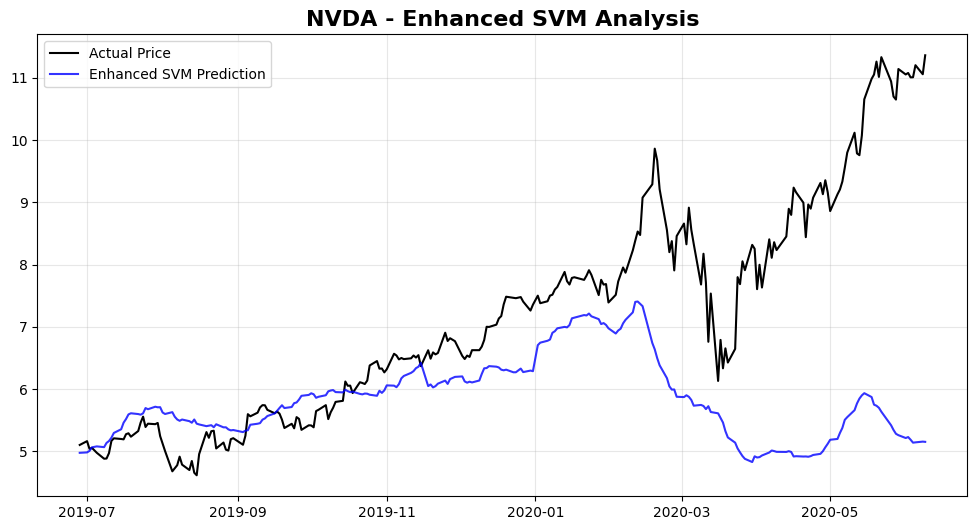

CPU times: user 117 ms, sys: 4.67 ms, total: 122 ms
Wall time: 121 ms


In [23]:
%%time
print("\n--- Preparing Enhanced Data for SVM ---")
# Reshape the enhanced data
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

print(f"Reshaped enhanced data for SVM: {X_train_svm_enh.shape}")

enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_enh)
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

enh_svm_preds_scaled = close_scaler_enh.inverse_transform(enh_svm_preds.reshape(-1, 1))
enhanced_svm_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_svm_preds_scaled, "Enhanced SVM"
)
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_svm_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced SVM",
)

### ARIMA Model


--- Running ARIMA Model ---
Performing rolling forecast for 239 steps...
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training comple

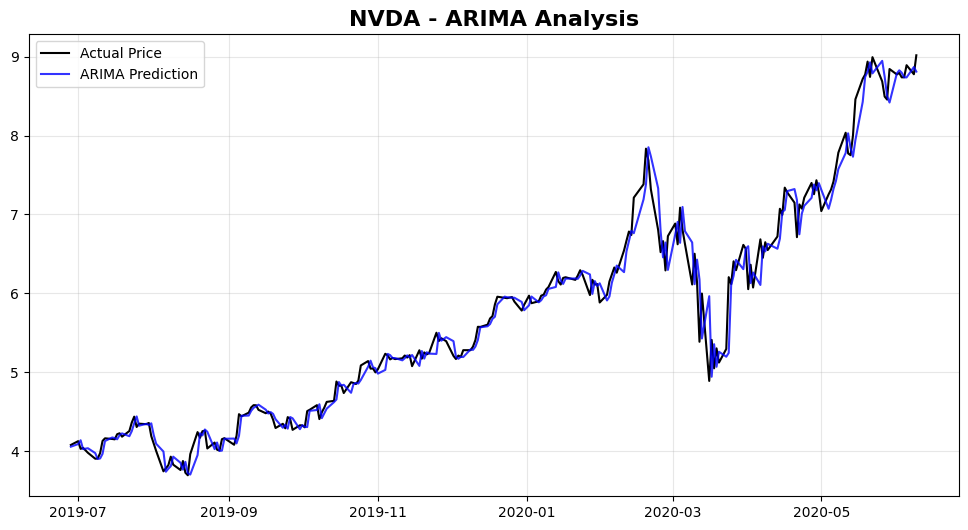

CPU times: user 40.4 s, sys: 528 ms, total: 40.9 s
Wall time: 41 s


In [24]:
%%time
print("\n--- Running ARIMA Model ---")
# ARIMA works on the unscaled, 1D time series of the target variable
close_prices = tech_data[cfg.BASELINE_TARGET]
train_size = int(len(close_prices) * (1 - cfg.TEST_SIZE))
train_arima, test_arima = close_prices[0:train_size], close_prices[train_size:]

history = [x for x in train_arima]
arima_predictions = []

print(f"Performing rolling forecast for {len(test_arima)} steps...")
for t in range(len(test_arima)):
    model_arima = mdl.build_and_train_arima(history)
    output = model_arima.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_arima[t]
    history.append(obs)

arima_predictions_np = np.array(arima_predictions).reshape(-1, 1)
y_test_arima_np = np.array(test_arima).reshape(-1, 1)
arima_metrics = ut.calculate_metrics(y_test_arima_np, arima_predictions_np, "ARIMA")
ut.plot_non_keras_results(
    y_test_arima_np, arima_predictions_np, test_arima.index, cfg.STOCK_SYMBOL, "ARIMA"
)

### 7. Final Performance Comparison

In [25]:
%%time
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, "Naive Baseline")

# --- UPDATED TO INCLUDE ALL MODELS ---
all_metrics_df = pd.DataFrame(
    [
        naive_metrics,
        baseline_metrics,
        enhanced_metrics,
        multi_layer_metrics,
        multi_enhanced_metrics,
        baseline_gru_metrics,
        enhanced_gru_metrics,
        baseline_svm_metrics,
        enhanced_svm_metrics,
        arima_metrics,
    ]
).round(4)

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))
print("-" * 60)

metrics_to_evaluate = {"RMSE": "min", "MAE": "min", "Directional_Accuracy": "max"}

print("\n🏆 Best Model for Each Metric")
print("-" * 30)
for metric, method in metrics_to_evaluate.items():
    if method == "min":
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        winner_idx = all_metrics_df[metric].idxmax()
    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")


📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                    Model   RMSE    MAE  Directional_Accuracy
           Naive Baseline 0.2669 0.1802               39.9160
        Single-Layer LSTM 0.3831 0.2445               47.4790
            Enhanced LSTM 0.4179 0.2673               47.0588
         Multi-Layer LSTM 0.5159 0.3415               46.2185
Multi-Layer Enhanced LSTM 0.5843 0.3914               44.5378
             Baseline GRU 0.4767 0.3117               47.4790
             Enhanced GRU 0.7011 0.4735               49.1597
                      SVM 2.1249 1.3283               51.6807
             Enhanced SVM 2.2644 1.4994               47.4790
                    ARIMA 0.2077 0.1383               42.8571
------------------------------------------------------------

🏆 Best Model for Each Metric
------------------------------
RMSE                  : ARIMA (Score: 0.2077)
MAE                   : ARIMA (Score: 0.1383)
Dir

In [26]:
%%time
ranking_df = all_metrics_df.copy()

ranking_df["RMSE_Rank"] = ranking_df["RMSE"].rank(method="min", ascending=True)
ranking_df["MAE_Rank"] = ranking_df["MAE"].rank(method="min", ascending=True)


ranking_df["DA_Rank"] = ranking_df["Directional_Accuracy"].rank(
    method="min", ascending=False
)

ranking_df["Total_Rank"] = (
    ranking_df["RMSE_Rank"] + ranking_df["MAE_Rank"] + ranking_df["DA_Rank"]
)

final_ranking = ranking_df.sort_values(by="Total_Rank", ascending=True)

print("-" * 40)
print("\\n🏆 Overall Model Ranking (Best to Worst)")
print("-" * 40)
print(
    final_ranking[["Model", "Total_Rank", "RMSE", "Directional_Accuracy"]]
    .reset_index(drop=True)
    .to_string()
)

----------------------------------------
\n🏆 Overall Model Ranking (Best to Worst)
----------------------------------------
                       Model  Total_Rank    RMSE  Directional_Accuracy
0          Single-Layer LSTM         9.0  0.3831               47.4790
1                      ARIMA        11.0  0.2077               42.8571
2               Baseline GRU        13.0  0.4767               47.4790
3             Naive Baseline        14.0  0.2669               39.9160
4              Enhanced LSTM        14.0  0.4179               47.0588
5               Enhanced GRU        18.0  0.7011               49.1597
6           Multi-Layer LSTM        19.0  0.5159               46.2185
7                        SVM        19.0  2.1249               51.6807
8  Multi-Layer Enhanced LSTM        22.0  0.5843               44.5378
9               Enhanced SVM        23.0  2.2644               47.4790
CPU times: user 2.21 ms, sys: 116 µs, total: 2.32 ms
Wall time: 2.26 ms


Plot saved to Output/NVDA_all_models_comparison.png


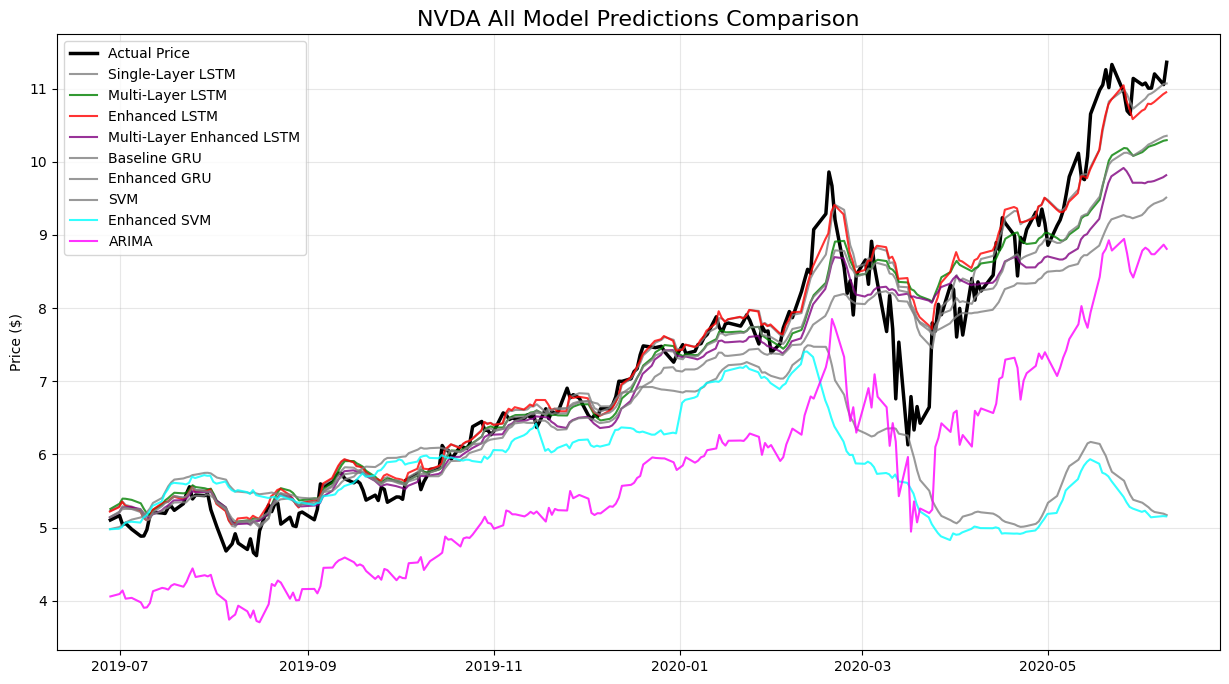

CPU times: user 168 ms, sys: 6.44 ms, total: 175 ms
Wall time: 174 ms


In [27]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
    "Baseline GRU": {"dates": test_dates_tech, "values": base_gru_preds_scaled},
    "Enhanced GRU": {"dates": test_dates_enh, "values": enh_gru_preds_scaled},
    "SVM": {"dates": test_dates_tech, "values": base_svm_preds_scaled},
    "Enhanced SVM": {"dates": test_dates_enh, "values": enh_svm_preds_scaled},
    "ARIMA": {"dates": test_arima.index, "values": arima_predictions_np},
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL)

In [28]:
try:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Total Notebook Runtime: {total_time:.2f} seconds ---")
except NameError:
    print("⚠️ --- Timer could not be stopped because 'start_time' was not defined.")

--- Total Notebook Runtime: 400.82 seconds ---
